In [3]:
import tensorflow as tf
import tensorflow.compat.v1 as tf1
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [23]:
(X_train, Y_train), (X_val, Y_val) = tf.keras.datasets.mnist.load_data()
print("Shape of feature matrix:", X_train.shape)
print("Shape of target matrix:", Y_train.shape)

Shape of feature matrix: (60000, 28, 28)
Shape of target matrix: (60000,)


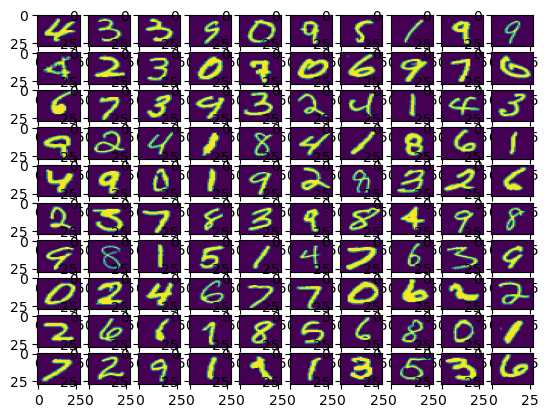

In [25]:
# Visualizing 100 random images from the dataset
fig, ax = plt.subplots(10, 10)
for i in range(10):
    for j in range(10):
        k = np.random.randint(0, X_train.shape[0])
        ax[i][j].imshow(X_train[k].reshape(28, 28), aspect='auto')
plt.show()

In [37]:
num_features = 784
num_labels = 10
learning_rate = 0.05
batch_size = 128
num_steps = 5001

# input data
train_dataset = X_train.reshape(-1, 784)
train_labels = pd.get_dummies(Y_train).values
valid_dataset = X_val.reshape(-1, 784)
valid_labels = pd.get_dummies(Y_val).values


In [47]:
# Initialize a TensorFlow graph
graph = tf.Graph()

with graph.as_default():
    # Inputs
    tf_train_dataset = tf1.placeholder(tf.float32, shape=(batch_size, num_features))
    tf_train_labels = tf1.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)

    # Variables (Weights and Biases)
    weights = tf.Variable(tf.random.truncated_normal([num_features, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))

    # Training computation
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        labels=tf_train_labels, logits=logits))

    # Optimizer
    optimizer = tf1.train.GradientDescentOptimizer(learning_rate).minimize(loss)

    # Predictions
    train_prediction = tf.nn.softmax(logits)
    tf_valid_dataset = tf.cast(tf_valid_dataset, tf.float32)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)

In [49]:
# Utility function to calculate accuracy
def accuracy(predictions, labels):
    correctly_predicted = np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
    acc = (100.0 * correctly_predicted) / predictions.shape[0]
    return acc

In [51]:
# To track weight changes and compute L-infinity norm
l_infinity_norms = []
previous_weights = None

In [53]:
with tf1.Session(graph=graph) as session:
    # Initialize weights and biases
    tf1.global_variables_initializer().run()
    print("Initialized")

    for step in range(num_steps):
        # Pick a randomized offset
        offset = np.random.randint(0, train_labels.shape[0] - batch_size)

        # Generate a minibatch
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]

        # Prepare the feed dict
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}

        # Run one step of computation
        _, l, predictions, current_weights = session.run(
            [optimizer, loss, train_prediction, weights],
            feed_dict=feed_dict
        )

        # Calculate L-infinity norm (maximum absolute weight change) if it's not the first iteration
        if previous_weights is not None:
            weight_change = current_weights - previous_weights
            l_infinity_norm = np.max(np.abs(weight_change))  # L-infinity norm
            l_infinity_norms.append(l_infinity_norm)

        # Store the current weights for the next iteration
        previous_weights = current_weights

        # Print stats every 500 iterations
        if step % 500 == 0:
            print(f"Minibatch loss at step {step}: {l:.4f}")
            print(f"Minibatch accuracy: {accuracy(predictions, batch_labels):.1f}%")
            print(f"Validation accuracy: {accuracy(valid_prediction.eval(), valid_labels):.1f}%")


Initialized
Minibatch loss at step 0: 3392.7458
Minibatch accuracy: 2.3%
Validation accuracy: 24.7%
Minibatch loss at step 500: 1275.0271
Minibatch accuracy: 82.0%
Validation accuracy: 87.7%
Minibatch loss at step 1000: 512.5093
Minibatch accuracy: 93.0%
Validation accuracy: 87.3%
Minibatch loss at step 1500: 223.2626
Minibatch accuracy: 92.2%
Validation accuracy: 89.1%
Minibatch loss at step 2000: 1005.6030
Minibatch accuracy: 82.8%
Validation accuracy: 89.2%
Minibatch loss at step 2500: 313.1525
Minibatch accuracy: 92.2%
Validation accuracy: 90.8%
Minibatch loss at step 3000: 1922.6918
Minibatch accuracy: 69.5%
Validation accuracy: 70.2%
Minibatch loss at step 3500: 1049.4628
Minibatch accuracy: 81.2%
Validation accuracy: 88.8%
Minibatch loss at step 4000: 310.4140
Minibatch accuracy: 97.7%
Validation accuracy: 91.2%
Minibatch loss at step 4500: 589.4144
Minibatch accuracy: 85.2%
Validation accuracy: 87.8%
Minibatch loss at step 5000: 429.3107
Minibatch accuracy: 93.8%
Validation acc

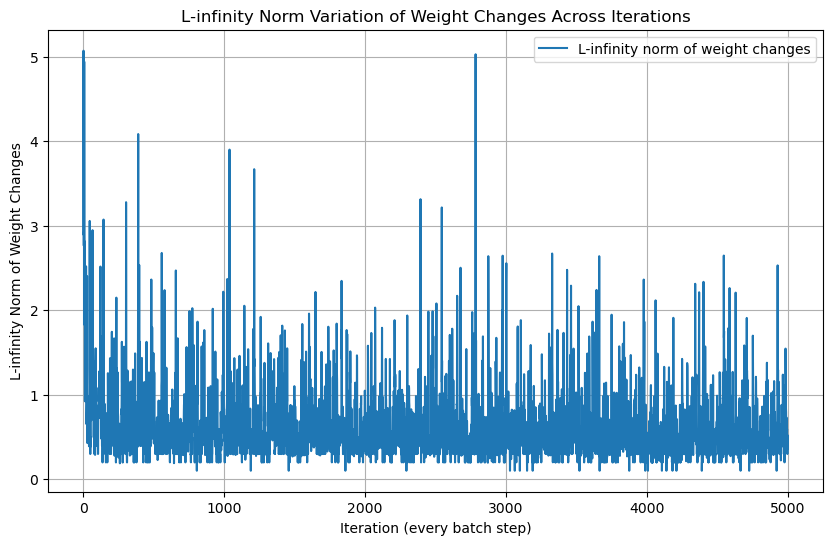

In [55]:
# Plot the L-infinity norm of weight changes across iterations
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(l_infinity_norms) + 1), l_infinity_norms, label='L-infinity norm of weight changes')
plt.xlabel('Iteration (every batch step)')
plt.ylabel('L-infinity Norm of Weight Changes')
plt.title('L-infinity Norm Variation of Weight Changes Across Iterations')
plt.legend()
plt.grid(True)
plt.show()